# Article IV Clustering by category: TF-IDF and k-means

In [1]:
#reference: http://brandonrose.org/clustering
import os, sys, re, csv
import heapq
import string
import gensim
import itertools
import json
from operator import itemgetter
import nltk
from nltk import *
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import matplotlib
#from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [2]:
# run this just in case something doesnt work out with corpus
def get_data():
    path1 = '/Users/dariaulybina/Desktop/georgetown-analytics_global-economics/global-economics/KeywordsANDClustering/FinalCleanJuly1.json'
    with open(path1) as datafile:
        data = json.load(datafile)
        datafile.close()
    return data
evrth = get_data()

In [3]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #ft = [f for f in filtered_tokens if f not in stp]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_tokens = [f for f in filtered_tokens]
    return filtered_tokens

In [7]:
def stem_evrth(evrth, cat):
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in range(0,len(evrth)):
        if evrth[i]['tag'] == cat:
            allwords_stemmed = tokenize_and_stem(evrth[i]['text']) #for each item in 'synopses', tokenize/stem
            totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
            allwords_tokenized = tokenize_only(evrth[i]['text'])
            totalvocab_tokenized.extend(allwords_tokenized)
            i = i + 1
        else:
            i = i + 1
    newframe = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    #print('there are {} items in vocabulary frame for category'.format(str(newframe.shape[0])))
    return newframe

In [9]:
# This output will show how the words will be stemmed and 
#each document will become represented by the list of stemmed words = tokenized
list3 = ['Fiscal', 'Monetary','Financial', 'Real','Risks','Context','External','Other']
dict33 = {}
for x in range(0,len(list3)):
    cat = list3[x]
    print(cat)
    newframe = stem_evrth(evrth,cat)
    #print(newframe.head())
    dict4 = {
        cat: newframe
    }
    dict33.update(dict4)
    x = x+1   

Fiscal
Monetary
Financial
Real
Risks
Context
External
Other


### Tf-idf and document similarity

Define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.
To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm).
Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

Defined parameters:

__max_df__: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining.

__min_idf__: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.1; the term must be in at least 10% of the document. Sometimes lower min_df you allow - more rare clustering will show up, for example, names- "" or "" found in several of the posts.

__ngram_range__: lookinf at unigrams, bigrams and trigrams or different.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
print("Extracting features from the training dataset using a sparse vectorizer")

# Create a sparse word occurrence frequency matrix of the most frequent words
# with the following parameters:
# Maximum document frequency = half the total documents
# Minimum document frequency = 10 documents
# Toss out common English stop words.
# Tokenizer is stemming
def fittting_stuff(contents):
    t0 = time()
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                       min_df=0.2, stop_words='english',
                                       use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(2,4))
    # Matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(contents)
    
    print("done in %fs" % (time() - t0))
    print("n_samples: %d, n_features: %d" % tfidf_matrix.shape)
    print()
    terms = tfidf_vectorizer.get_feature_names()
    #print(terms)
    return tfidf_matrix, terms

Extracting features from the training dataset using a sparse vectorizer


In [8]:
#Uncomment if looking into all text
#contents=[]
#for x in evrth:
    #contents.append(x['text'])

In [11]:
#Look into the general matrix alltogether
#tfidf_matrix, terms = fittting_stuff(contents)

done in 71.961617s
n_samples: 2066, n_features: 25



In [11]:
#Those TF-IDF are not run on the whole set of tests but by category they belong to
list3 = ['Fiscal', 'Monetary','Financial','Real','Risks','Context','External','Other']
mlist = []
for y in range(0,len(list3)):
    contents = []
    for z in range(0,len(evrth)):
        if evrth[z]['tag'] == list3[y]:
            contents.append(evrth[z]['text'])
            z = z + 1
        else:
            z = z + 1
    print(len(contents))
    print(list3[y])
    tfidf_matrix, terms = fittting_stuff(contents)
    dicty = {
        'category':  str(list3[y]),
        'matrix': tfidf_matrix,
        'terms': terms
    }
    mlist.append(dicty)
    print()
    y = y + 1

265
Fiscal
done in 11.787891s
n_samples: 265, n_features: 81


128
Monetary
done in 3.838122s
n_samples: 128, n_features: 44


215
Financial
done in 8.113971s
n_samples: 215, n_features: 44


345
Real
done in 12.701474s
n_samples: 345, n_features: 40


249
Risks
done in 9.132909s
n_samples: 249, n_features: 82


510
Context
done in 12.954867s
n_samples: 510, n_features: 20


53
External
done in 1.394915s
n_samples: 53, n_features: 60


301
Other
done in 8.751385s
n_samples: 301, n_features: 9




In [13]:
# check number of items in a list - should equal number of predefined categories
print(len(mlist))

8


In [12]:
from sklearn.cluster import KMeans, MiniBatchKMeans
# Set the number of clusters to 15, Put in the pipline????

def cluster_fit(k,tfidf_matrix,terms):
    # Initialize the kMeans cluster model.
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    print("Clustering sparse data with %s" % km)
    t0 = time()
    # Pass the model our sparse matrix with the TF-IDF counts.
    km.fit(tfidf_matrix)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    numbers = []
    vals = []
    for i in range(k):
        print("Cluster %d:" % (i+1), end='')
        l1 = []
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
            l1.append(terms[ind])
        string1 = ','.join(l1)
        numbers.append(i+1)
        vals.append(string1)
        print()
    # Dictionary of cluster names and ids
    cluster_names={}
    for n in range(0,len(numbers)):
        d = {}
        d[numbers[n]] = vals[n]
        cluster_names.update(d)
    return km, cluster_names

In [14]:
# For looking at the whole text 
#k = 5
#km, cluster_names = cluster_fit(k,tfidf_matrix,terms)
#joblib.dump(km, 'all_cluster.pkl')
#clusters = km.labels_.tolist()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 2.270s

Top terms per cluster:
Cluster 1: percent gdp public debt medium term percentag point public sector staff estim fiscal consolid imf staff fiscal polici current account
Cluster 2: exchang rate monetari polici central bank percent gdp current account medium term imf staff structur reform author view fiscal polici
Cluster 3: financi sector privat sector structur reform author view percent gdp central bank monetari polici fiscal polici view author author view author
Cluster 4: privat sector structur reform author view medium term view author imf staff author view author author agre public sector staff calcul
Cluster 5: current account oil price percent gdp exchang rate gdp growth real gdp medium term imf staff staff calcul staff estim


In [13]:
#For categories splitting 
cluster_topics = {}
for m in mlist:
    category = m['category']
    print("FOR CATEGORY {}".format(category))
    tfidf_matrix = m['matrix']
    terms = m['terms']
    #if cat == 'Fiscal' or cat == 'Monetary':
        #k = 5
    #elif cat == 'Risks' or cat == 'External' or cat=='Real':
        #k == 3 #2
    #elif cat == 'Context':
        #k == 7
    #else:
        #k = 5
    k =5
    km, cluster_names = cluster_fit(k,tfidf_matrix,terms)
    joblib.dump(km, category+'5_cluster.pkl')
    #km = joblib.load(category+'5_cluster.pkl')
    clusters = km.labels_.tolist()
    cln = {
        category: cluster_names   
    }
    cluster_topics.update(cln)
    print(clusters)
    print()
print(cluster_topics)

FOR CATEGORY Fiscal
Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 0.606s

Top terms per cluster:
Cluster 1: privat sector public sector public spend author plan world bank public invest incom tax medium term tax administr author agre
Cluster 2: percent gdp public debt fiscal consolid public sector fiscal adjust incom tax central govern medium term fiscal deficit deficit percent
Cluster 3: percent gdp fiscal rule staff calcul fiscal polici general govern fiscal stanc imf staff public invest imf staff calcul fiscal balanc
Cluster 4: percent gdp debt sustain public invest technic assist fiscal framework financi manag fiscal polici capit spend staff welcom medium-term fiscal
Cluster 5: percent gdp percentag point point gdp percentag point gdp public debt fiscal consolid fiscal adjust medium term incom tax fiscal defici

In [67]:
MyList = []
articles4 = {}
for c in range(0,len(mlist)):
    cat = mlist[c]['category']
    km = joblib.load(cat+'3_cluster.pkl')
    clusters = km.labels_.tolist()
    ct = cluster_topics[cat]
    titles = [item['header'] for item in evrth if item['tag']==cat ]
    dates = [item['year'] for item in evrth if item['tag']==cat]
    countries = [item['country'] for item in evrth if item['tag']==cat]
    contents = [item['text'] for item in evrth if item['tag']==cat]
    ides = [item['key1'] for item in evrth if item['tag']==cat]
    ides2_forD = [item['key2'].replace('.txt','') for item in evrth if item['tag']==cat]
    ides2 = [item['key2'] for item in evrth if item['tag']==cat]
    for b in range(0,len(ides)): 
        articles = {'cat': cat,'words':ct[clusters[b]+1], 'key2':ides2[b],'title': titles[b] ,'id':"'"+ides[b],
                       'country':countries[b],'cluster': clusters[b]+1, 'date': dates[b] }
        MyList.append(articles)
        b = b + 1
    dictionary = {cat: {'words':ct, 'key2':ides2_forD,'title': titles ,'id':ides,'country':countries,'cluster': clusters,
                        'date': dates}}
    articles4.update(dictionary)
    c = c + 1

In [69]:
MyList[65]

{'cat': 'Fiscal',
 'cluster': 3,
 'country': 'Bulgaria',
 'date': '2013',
 'id': "'-doc-_cr1423_4.txt",
 'key2': 'Bulgaria2013_4.txt',
 'title': 'A. Fiscal Policy: Safeguarding Consolidation and Improving Spending',
 'words': 'percent gdp,public debt,fiscal consolid,public sector,medium term,fiscal adjust,central govern,fiscal deficit,deficit percent,incom tax'}

In [70]:
len(MyList)

2066

In [71]:
#Save to CSV file
detail_key = ['cat','words','key2','title','id','country','cluster','date']
with open(os.path.join('outputClusteringk3.csv'), 'w', newline ='', encoding = 'utf-8') as output_file:
        writer = csv.DictWriter(output_file, detail_key)
        writer.writeheader()
        writer.writerows(MyList)
        output_file.close()

In [72]:
import json
a4 = json.dumps(articles4)
with open("outputClusteringk3.json","w") as f:
    f.write(a4)

### Vizualizing clusters

In [93]:
from sklearn.metrics.pairwise import cosine_similarity
############# Just observe and change the cluster manually!
############ Each needs individual approach and judgment + attention, no 'pipeline'
category = "Fiscal"
for m in mlist:
    if m['category'] == category:
        tfidf_matrix = m['matrix']
dist = 1 - cosine_similarity(tfidf_matrix)

In [94]:
#Multidimentional scaling 
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [95]:
# Codes borrowed from http://tools.medialab.sciences-po.fr/iwanthue/

# This code is supposed to match each topic identified with a color and cluster documents according to cluster assigned
#colors15 = ["#001611","#4dff62","#910079","#ffe021","#005cc8","#f2ffa7","#46003c",
# "#62ffc1","#ff359b","#017196","#ff515b","#ccdfff","#a52d00","#ff8b9b","#550c00"]

colors5 = ["#001611","#4dff62","#910079","#ffe021","#005cc8"]
cluster_colors = {}

for i in range(0,len(colors5)):
    cc = {
        i+1:colors5[i]
    }
    cluster_colors.update(cc)

print(cluster_colors)
cluster_names = cluster_topics['Fiscal']
print(cluster_names)

{1: '#001611', 2: '#4dff62', 3: '#910079', 4: '#ffe021', 5: '#005cc8'}
{1: 'exchang rate,financi sector,monetari polici,privat sector,imf staff,medium term,staff estim,percent gdp,structur reform', 2: 'percent gdp,staff estim,imf staff,exchang rate,monetari polici,privat sector,medium term,structur reform,financi sector', 3: 'structur reform,medium term,monetari polici,privat sector,percent gdp,financi sector,exchang rate,imf staff,staff estim'}


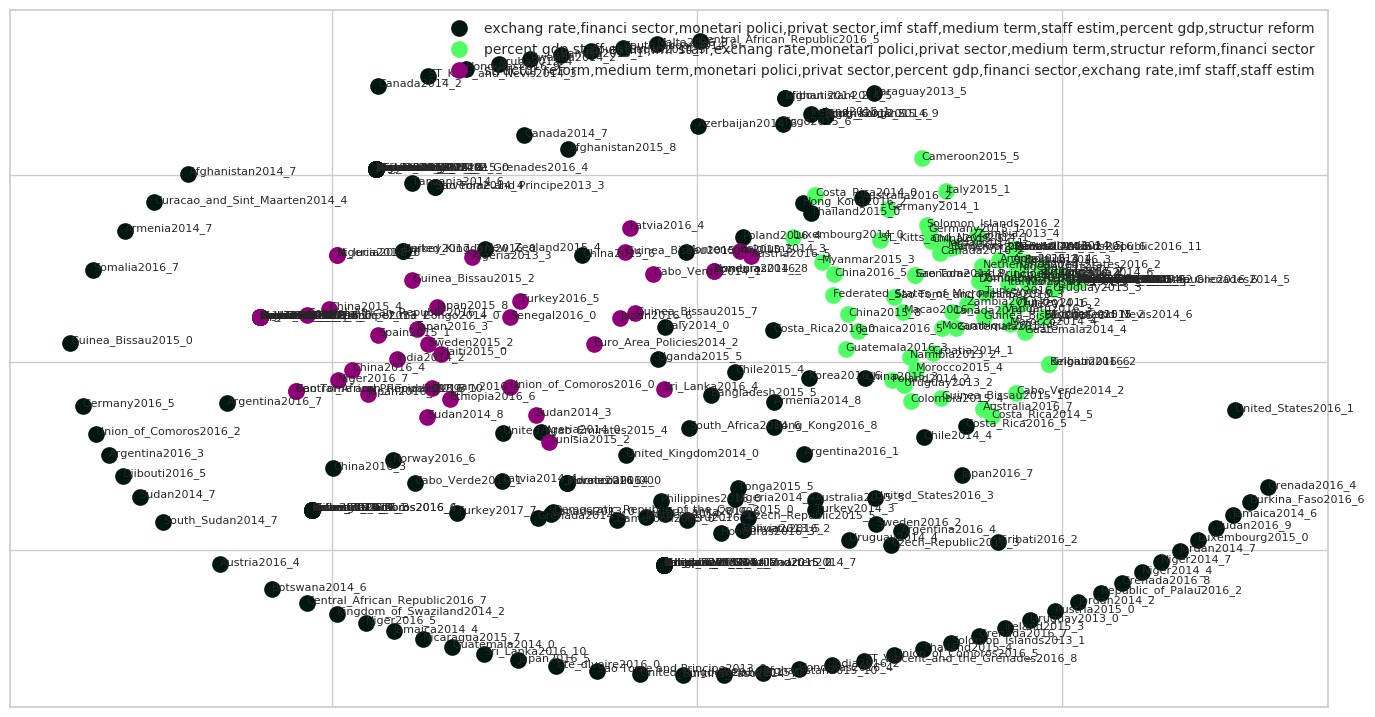

In [96]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
clusters = articles4['Fiscal']['cluster']
frame = pd.DataFrame(articles4['Fiscal'], index = [clusters] , columns = ['id','words','key2','title','text','cluster','date'])
#create data frame that has the result of the MDS plus the cluster numbers and id
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=articles4['Fiscal']['key2'])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name+1], color=cluster_colors[name+1], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)


## Looks like there might be actually 2-3 clusters in 'Fiscal' category

#### Elbow method to find optimal number of clusters

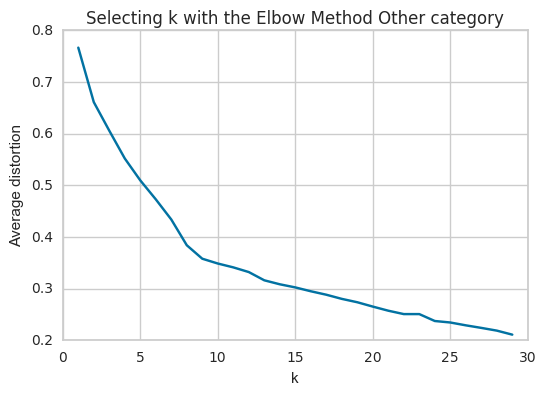

In [98]:
### TFIDF was defined for Fiscal category previously
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

K = range(1,30)
meandistortions = []

for k in K:

    elbow = KMeans(n_clusters=k, n_jobs=-1, random_state=1)
    elbow.fit(tfidf_matrix)
    meandistortions.append(sum(np.min(euclidean_distances(tfidf_matrix, elbow.cluster_centers_), axis=1)) / tfidf_matrix.shape[0])

    
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method Other category')
plt.show()

## Elbow chart for 'fiscal' category
If the elbow chart looks like an arm, then the "elbow" on the arm would be the value of k that is the best. In other words, the goal is to achieve a small SSE and the small value of k, since the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

In the case above, the elbow method worked. We don't see a smooth curve, and it's clear that we should aim at 2-3 clusters for fiscal topics

To be more precise, use elbow scores below

## Silhouette Scores

Silhouette scores study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For 'Fiscal' category, k = 3
For 'Context' category, k = 3 with score = 0.139(max)

In [99]:
k = [2,3,4,5]
for x in k:
    kmeans = KMeans(n_clusters=x, n_jobs=-1, random_state=1)
    kmeans.fit(tfidf_matrix)
    labels = kmeans.labels_
    print("For k = {}, silhouette score is {}".format(x,silhouette_score(tfidf_matrix, labels, metric='euclidean')))

For k = 2, silhouette score is 0.2333610003304735
For k = 3, silhouette score is 0.2733981034513803
For k = 4, silhouette score is 0.31478670922376334
For k = 5, silhouette score is 0.3527514294481267


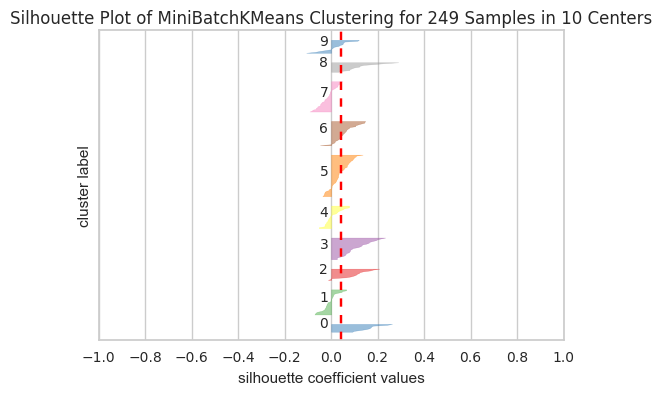

In [87]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Instantiate the clustering model and visualizer 
model = MiniBatchKMeans(10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(tfidf_matrix) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [100]:
#define custom toolbar location
import mpld3
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

### Hover over clustered chart (country + year displayed)

In [104]:
titles=articles4['Other']['key2']
#create data frame that has the result of the MDS plus the cluster numbers and id
df = pd.DataFrame(dict(x=xs, y=ys, label=articles4['Other']['cluster'], title=articles4['Other']['key2'])) 

#create data frame that has the result of the MDS plus the cluster numbers and titles
#df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name+1], mec='none', 
                     color=cluster_colors[name+1])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

__Lining up of items and Ward Clustering__<br><br>
Trying hierarchical clustering (Ward clustering) revealed about 2-3 clusters per topic. Although some categores were clustering well especially with Ward (fiscal, Monetary, Financial), texts with very short - "cut" content were affecting our results and introducing uncessary noise that ended up being significant in those situations. Because of those cut sentences, we observe the circular line up i nthe k-means clustering

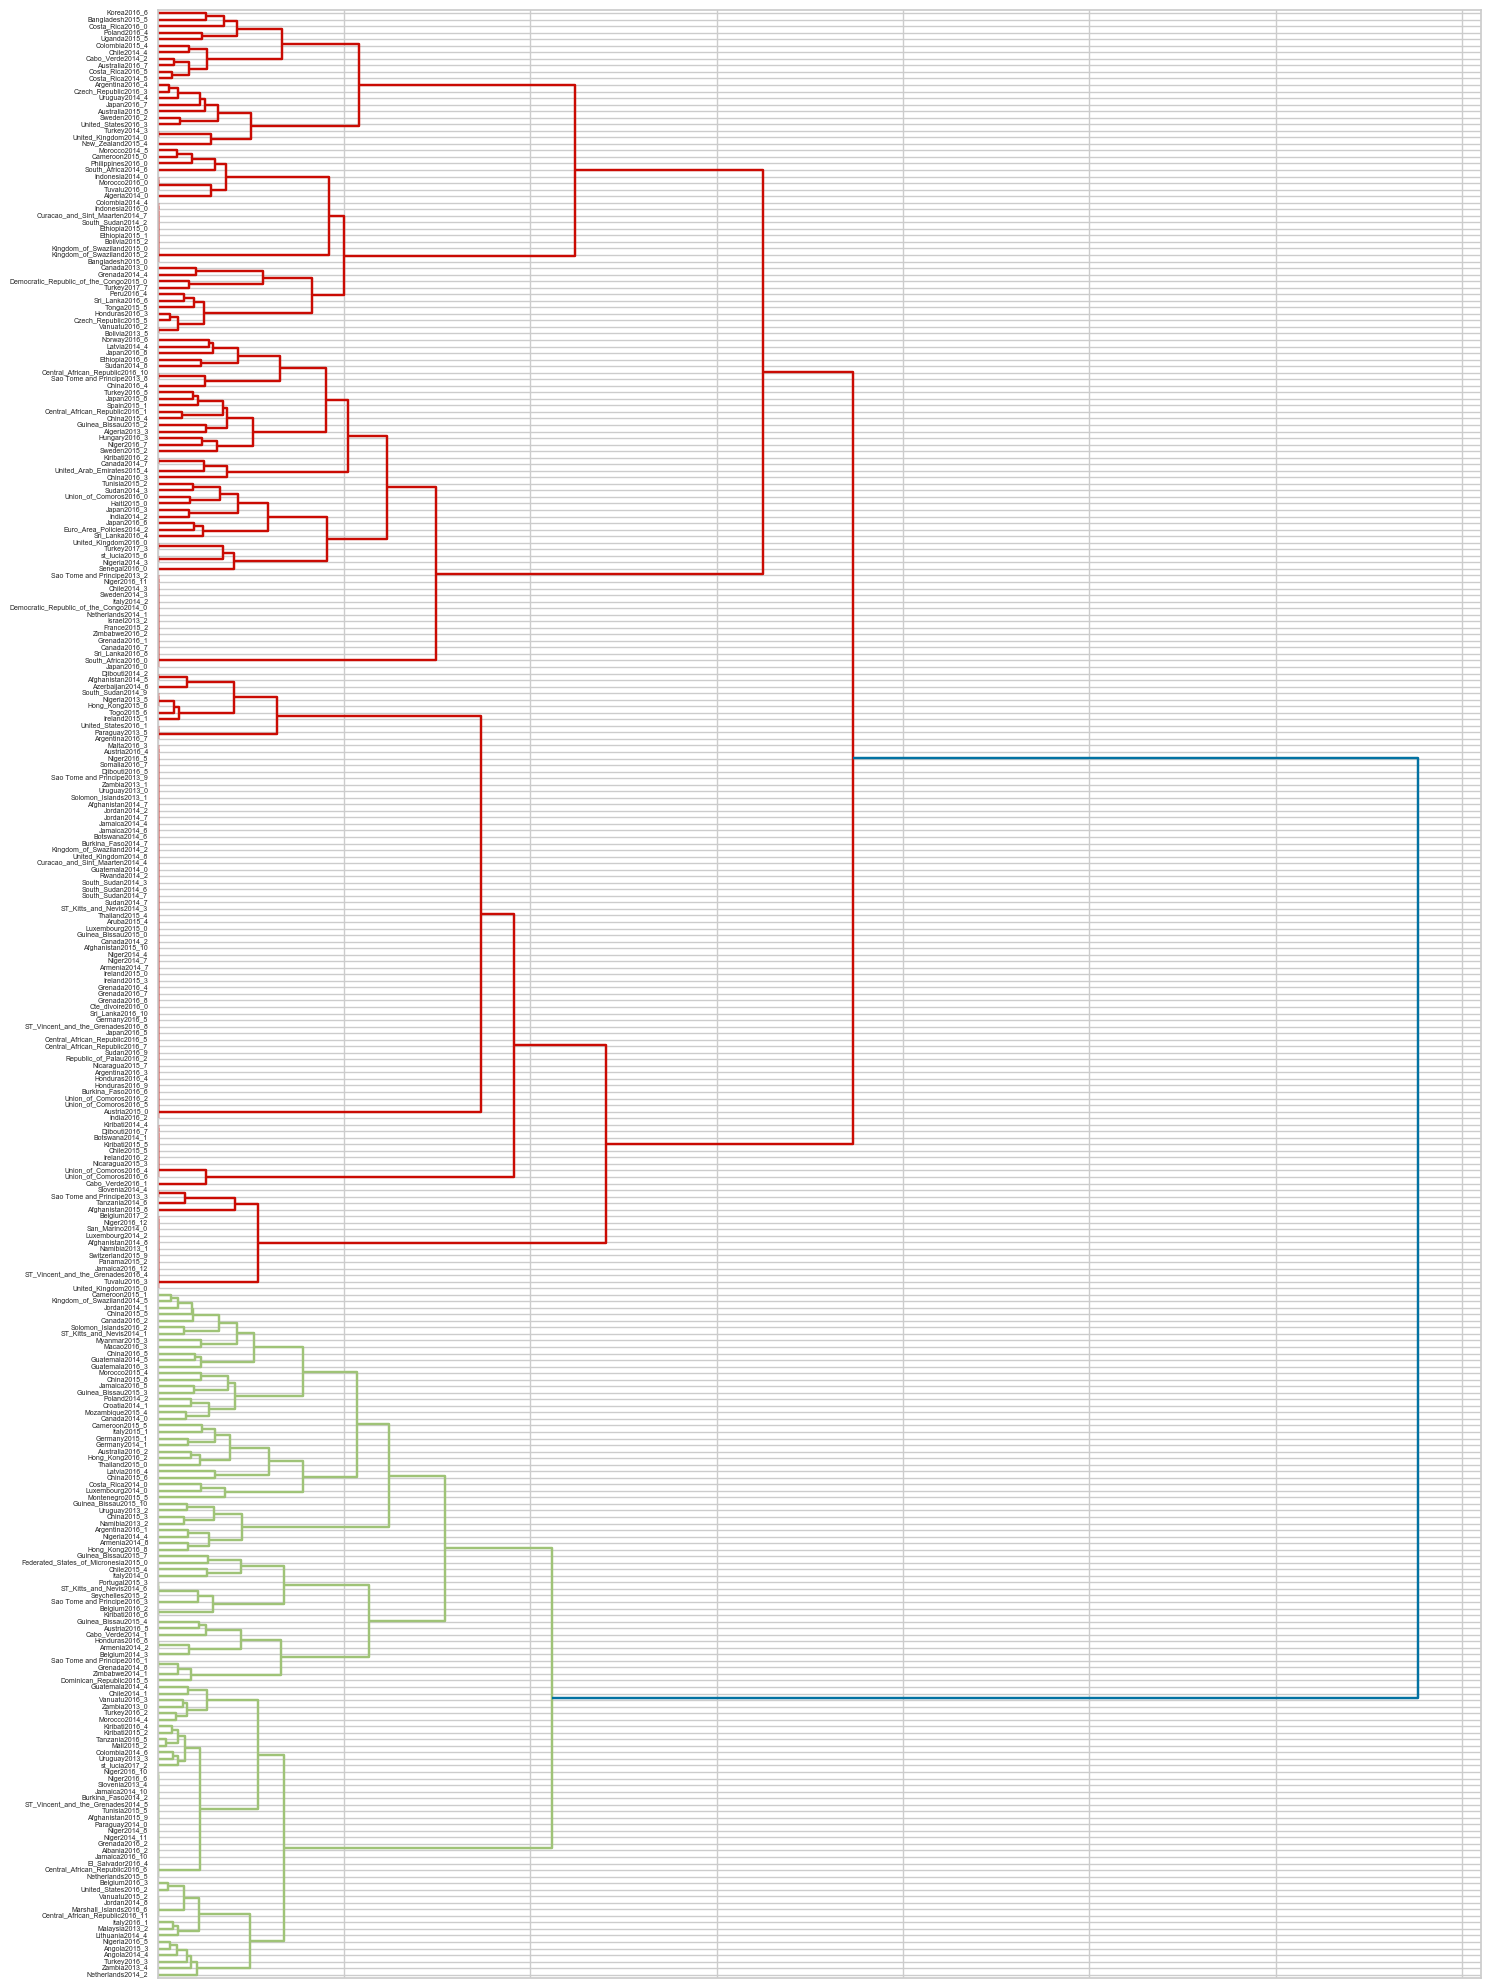

In [105]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clustersM.png', dpi=200) #save figure as ward_clusters